
# Associate Ca2+ signal with sleep stages

Load packages

In [2]:
cd "C:/Users/Manip2/SCRIPTS/Code python audrey/code python aurelie/interfaceJupyter/minian"

C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian


In [3]:
import quantities as pq
import numpy as np
import neo
import json
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
%matplotlib widget

from ephyviewer import mkQApp, MainViewer, TraceViewer

from minian.utilities import (
    TaskAnnotation,
    get_optimal_chk,
    load_videos,
    open_minian,
    save_minian,
)

Load sleep score and Ca2+ time series numpy arrays

In [165]:
folder_base = Path('//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording/BlackLinesOK/session1')

folder_Ephys = folder_base / f'OpenEphys/'
folder_Minis = folder_base / f'V4_Miniscope/minianAB/'
print(folder_Minis)
filenameE = folder_Ephys / f'ScoredSleep.npy'
SleepScoredTS = np.load(filenameE)
filenameB = folder_base / f'SynchroFile.xlsx'
stamps = pd.read_excel(filenameB)
minian_ds = open_minian(folder_Minis)

TodropFile = folder_Minis / f'TodropFileAB.json'
with open(TodropFile, 'r') as f:
    unit_to_drop = json.load(f)


\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\Baseline_recording\BlackLinesOK\session1\V4_Miniscope\minianAB
[0]


Identify start time and upscale scoring to miniscope acquisition frequency


In [230]:
# start time & freq miniscope
StartTime = (list(stamps[0])[0])
minian_freq=list(stamps[0])[2]

# update start time of Ca2+ imaging time series
First_frame = StartTime*minian_freq
C = minian_ds['C'] # calcium traces 
Cupd = C.loc[:, First_frame:]
nb_unit = Cupd.shape[0]
rec_dur = Cupd.shape[1]

S = minian_ds['S'] # estimated spikes 
Supd = S.loc[:, First_frame:]

# Upscale scoring to miniscope frequency
scale_factor=minian_freq/0.2  #cause scoring was done in 5 seconds bin, ie 0.2 Hz
SleepScoredTS_upscaled = np.repeat(SleepScoredTS, scale_factor, axis=0)
StartTime_frame=int(StartTime*minian_freq)
SleepScoredTS_upscaled_ministart=SleepScoredTS_upscaled[int(StartTime_frame):int(StartTime_frame)+rec_dur]

print(nb_unit, 'units recorded')
print(rec_dur, 'miniscope frames')
print('Miniscope freq  =', minian_freq, 'fps')
print('Miniscope recording time =', rec_dur/minian_freq, 'sec')
print('Ephys recording time =',len(SleepScoredTS_upscaled_ministart)/minian_freq, 'sec')


33 units recorded
5158 miniscope frames
Miniscope freq  = 20 fps
Miniscope recording time = 257.9 sec
Ephys recording time = 257.9 sec


In [231]:
A = minian_ds['A']
print('Unit values to drop =', unit_to_drop)

B = A['unit_id']
copyB = list(B.copy())
for i in range(len(unit_to_drop)):
    elem = unit_to_drop[i]
    copyB.remove(elem)
unit_to_keep = copyB

C_upd = Cupd.loc[unit_to_keep,:]
S_upd = Supd.loc[unit_to_keep,:]
nb_unit = C_upd.shape[0]
print(len(C_upd.unit_id), 'selected units')

Unit values to drop = [0]
32 selected units


Example unit & scoring pairing

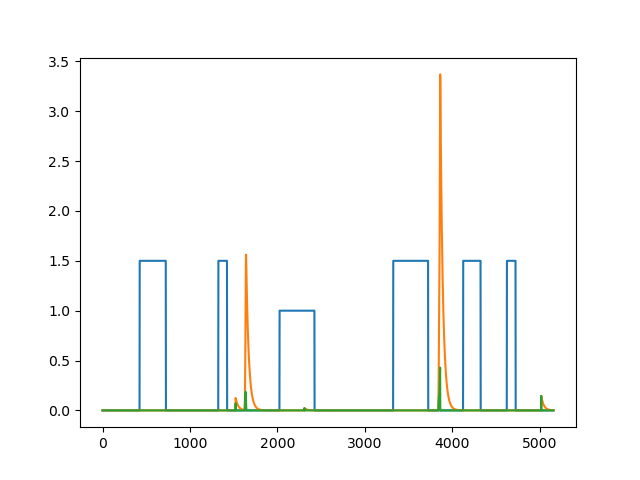

In [233]:
Test2 = C_upd.to_series()
unit = 1
lTest2 = np.array(Test2)[(unit)*rec_dur:(unit+1)*rec_dur]
Test3 = S_upd.to_series()
lTest4 = np.array(Test3)[(unit)*rec_dur:(unit+1)*rec_dur]


plt.close()
plt.plot(SleepScoredTS_upscaled_ministart)
plt.plot(lTest2)
plt.plot(lTest4)
plt.show()

Determine each substate identity and duration

In [211]:
from itertools import groupby

array=SleepScoredTS_upscaled_ministart
substates_duration = [len(list(group)) for key, group in groupby(array)]
substates_identity = [key for key, _ in groupby(array)]
substates_end = np.array(substates_duration).cumsum()
substates_start =np.append([1],substates_end+1)

# Replacing numbers with sleep stage
mapp = {
    0: 'NREM',
    0.5: 'N2',
    1: 'REM',
    1.5: 'Wake',
}
substates_identity = [mapp[num] for num in substates_identity]

substates = pd.DataFrame(list(zip(substates_identity, substates_duration, substates_start, substates_end)), columns=['Identity', 'Duration', 'Start','End'])

Distribute Ca2+ intensity to vigilance state

In [229]:
data = {
    'Mice':np.zeros(nb_unit*len(substates)),
    'Session' : np.zeros(nb_unit*len(substates)),
    'UnitNumber':np.zeros(nb_unit*len(substates)),
    'UnitValue':np.zeros(nb_unit*len(substates)),
    'Substate' : np.zeros(nb_unit*len(substates)),
    'SubstateNumber' : np.zeros(nb_unit*len(substates)),
    'DurationSubstate' : np.zeros(nb_unit*len(substates)),
    'AvgCalciumActivity' : np.zeros(nb_unit*len(substates)),
    'AUC' : np.zeros(nb_unit*len(substates)),
}
GlobalResults= pd.DataFrame(data, columns=['Mice','Session','UnitNumber','UnitValue', 'Substate','SubstateNumber','DurationSubstate', 'AvgCalciumActivity', 'AUC'])

C_upd_unit_id = C_upd['unit_id'].values #added by AB
counter=0
input_all = C_upd.to_series()

for unit in range(nb_unit): # nb_unit):
    input_arr = np.array(input_all)[(unit)*rec_dur:(unit+1)*rec_dur]
    for index in range(len(substates)):
        input_arr_sub=input_arr[substates.Start[index]:substates.End[index]]
        GlobalResults.loc[counter, 'Mice'] = None #to define later
        GlobalResults.loc[counter, 'Session'] = None #to define later
        GlobalResults.loc[counter, 'UnitNumber'] = unit
        GlobalResults.loc[counter, 'UnitValue'] = C_upd_unit_id[unit]
        GlobalResults.loc[counter, 'Substate'] = substates.Identity[index]
        GlobalResults.loc[counter, 'SubstateNumber'] = substates.index[index]
        GlobalResults.loc[counter, 'DurationSubstate'] = substates.Duration[index]
        GlobalResults.loc[counter, 'AvgCalciumActivity'] = input_arr_sub.mean()
        GlobalResults.loc[counter, 'AUC'] = np.trapz(input_arr_sub,np.arange(0,len(input_arr_sub),1))
        counter+=1


C:\Users\Manip2\AppData\Local\Temp\ipykernel_840172\2887713751.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NREM' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  GlobalResults.loc[counter, 'Substate'] = substates.Identity[index]


Normalise

In [357]:
# Double normalisation 1- by total fluorescence per cell 2- by time spent in each state.
Activity_state_n = Activity_state.copy()
row_sums = Activity_state_n.sum(axis=1)
Activity_state_n = Activity_state_n.div(row_sums, axis=0) #Activity_state_n = Activity_state_n / row_sums[:, np.newaxis]
# % of fluorescence power observed relative to what would have been expected if intensity was uniformally distributed
RelativeWeight = round(Activity_state_n / Activity_state_time.loc['percentage'] * 100)
RelativeWeight.apply(np.sum, axis=0)/nb_unit

N2      34.357143
NREM    67.178571
REM      0.000000
Unit     0.000000
Wake    79.607143
dtype: float64

In [358]:
"""filenameUnit = folder_Minis / f'UnitToKeepAB.xlsx'
unitname = pd.read_excel(filenameUnit)
RelativeWeight['Unit'] =  unitname[0]
"""
RelativeWeight["Unit"]=C_upd_unit_id #added by AB


filenameOut = folder_base / f'IntensityNormalisedVigilanceStatesAB.xlsx'
writer = pd.ExcelWriter(filenameOut)
RelativeWeight.to_excel(writer)
writer.close()

Do the same but instead of fluorescence intensity, use active frames

In [359]:
data = {
    'Unit':np.zeros(nb_unit),
    'Wake' : np.zeros(nb_unit),
    'NREM' : np.zeros(nb_unit),
    'N2' : np.zeros(nb_unit),
    'REM' : np.zeros(nb_unit),
}
Activity_state_frame = pd.DataFrame(data, columns=['Unit', 'Wake', 'NREM', 'N2', 'REM'])

for unit in range(nb_unit):
    lTest2 = np.array(Test2)[(unit)*rec_dur:(unit+1)*rec_dur]
    input_arr = lTest2
    R = round(len(lTest2)/(5*list(stamps[0])[2])) # 5 sec bins
    split_arr = np.linspace(0, len(input_arr), num=R+1, dtype=int)
    dwnsmpl_subarr = np.split(input_arr, split_arr[1:])
    dwnsmpl_arrT = np.array( list( np.mean(item) for item in dwnsmpl_subarr[:-1] ) )
    dwnsmpl_arrT = dwnsmpl_arrT[0:len(SleepScoredTSupd)]
    Activity_state_frame["Unit"][unit] = C_upd_unit_id[unit] #added by AB
    for time_stamp in range(len(dwnsmpl_arrT)):
        if((SleepScoredTSupd2[time_stamp] == 1) and (dwnsmpl_arrT[time_stamp] > 0)):
            Activity_state_frame["REM"][unit] = Activity_state_frame["REM"][unit] + 1    
        elif((SleepScoredTSupd2[time_stamp] == 0.5) and (dwnsmpl_arrT[time_stamp] > 0)):
            Activity_state_frame["N2"][unit] = Activity_state_frame["N2"][unit] + 1    
        elif((SleepScoredTSupd2[time_stamp] == 1.5) and (dwnsmpl_arrT[time_stamp] > 0)):
            Activity_state_frame["Wake"][unit] = Activity_state_frame["Wake"][unit] + 1     
        elif((SleepScoredTSupd2[time_stamp] == 0) and (dwnsmpl_arrT[time_stamp] > 0)):
            Activity_state_frame["NREM"][unit] = Activity_state_frame["NREM"][unit] + 1     


In [360]:
# Double normalisation 1- by total fluorescence per cell 2- by time spent in each state.
Activity_state_frame_n = Activity_state_frame.copy()
Activity_state_frame_n.apply(np.sum, axis=1)
row_sums_frame = Activity_state_frame_n.sum(axis=1)
Activity_state_n = Activity_state_n.div(row_sums, axis=0)# Activity_state_frame_n = Activity_state_frame_n / row_sums_frame[:, np.newaxis]
# % of fluorescence power observed relative to what would have been expected if intensity was uniformally distributed
RelativeWeight_frame = round(Activity_state_frame_n / Activity_state_time.loc['percentage'] * 100)
RelativeWeight_frame.apply(np.sum, axis=0)/nb_unit

N2      11044.928571
NREM    10434.535714
REM         0.000000
Unit        0.000000
Wake    10756.821429
dtype: float64

In [361]:
Activity_state_frame

,Unit,Wake,NREM,N2,REM
0,0.0,39.0,77.0,7.0,0.0
1,1.0,27.0,50.0,7.0,0.0
2,3.0,33.0,53.0,6.0,0.0
3,4.0,39.0,77.0,7.0,0.0
4,5.0,35.0,60.0,7.0,0.0
5,6.0,31.0,75.0,7.0,0.0
6,7.0,32.0,71.0,7.0,0.0
7,8.0,37.0,70.0,7.0,0.0
8,9.0,34.0,74.0,7.0,0.0
9,10.0,39.0,77.0,7.0,0.0


In [362]:
filenameOut = folder_base / f'NumFrameNormalisedVigilanceStatesAB.xlsx'
writer = pd.ExcelWriter(filenameOut)
RelativeWeight_frame.to_excel(writer)
writer.close()


In [363]:
Activity_state_time

,Wake,NREM,N2,REM
absolu,39.000000,77.000000,7.000000,0.0
percentage,0.317073,0.626016,0.056911,0.0
